In [1]:
%reset -f
from wavhandler import *
from utils_train import train_test_val_split
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
Using TensorFlow backend.


In [2]:
data = Dataset('Wingbeats')
data.target_classes

['Ae. aegypti',
 'Ae. albopictus',
 'An. arabiensis',
 'An. gambiae',
 'C. pipiens',
 'C. quinquefasciatus']

### Ae. Aegypti

In [3]:
data1 = Dataset('Wingbeats')
data1.read('Ae. aegypti', loadmat=False)
data1.get_sensor_features();

Data: Ae. aegypti.
Read 85553 filenames in 2.30 seconds.


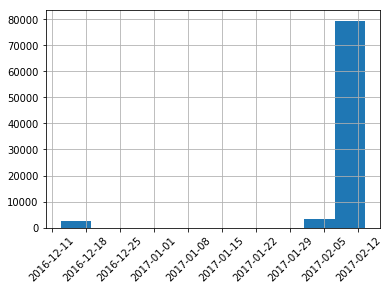

In [4]:
data1.df_features.date.hist(xrot=45)

In [5]:
sub = data1.df_features
inds_1 = sub[sub.date < '2017-01-01'].index

### Ae. albopictus

In [6]:
data2 = Dataset('Wingbeats')
data2.read('Ae. albopictus', loadmat=False)
data2.get_sensor_features(temp_humd=False)

Data: Ae. albopictus.
Read 20231 filenames in 2.20 seconds.


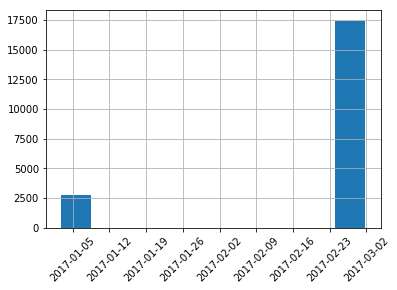

In [7]:
data2.df_features.date.hist(xrot=45)

In [8]:
sub = data2.df_features
inds_2 = sub[sub.date < '2017-01-12'].index

### An. arabiensis

In [9]:
data3 = Dataset('Wingbeats')
data3.read('An. arabiensis', loadmat=False)

data3.get_sensor_features(temp_humd=False)

Data: An. arabiensis.
Read 19297 filenames in 2.24 seconds.


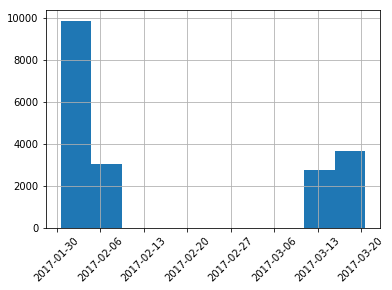

In [10]:
data3.df_features.date.hist(xrot=45)

In [11]:
sub = data3.df_features
inds_3 = sub[sub.date > '2017-03-17'].index

### An. gambiae

In [12]:
data4 = Dataset('Wingbeats')
data4.read('An. gambiae', loadmat=False)

data4.get_sensor_features(temp_humd=False)

Data: An. gambiae.
Read 49471 filenames in 2.16 seconds.


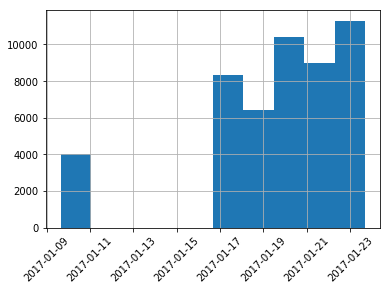

In [13]:
data4.df_features.date.hist(xrot=45)

In [14]:
sub = data4.df_features
inds_4 = sub[sub.date < '2017-01-11'].index

### Culex quinquefasciatus

In [15]:
data5 = Dataset('Wingbeats')
data5.read('C. quinquefasciatus', loadmat=False)

data5.get_sensor_features(temp_humd=False)

Data: C. quinquefasciatus.
Read 74599 filenames in 2.16 seconds.


In [16]:
sub = data5.df_features
# inds_5 = sub[sub.date < '2016-12-20'].index
print(data5.df_features.query('date_day == 20').shape)
inds_5 = data5.df_features.query('date_day == 20').sample(2500).index
index_drop = data5.filenames[ (~data5.filenames.index.isin(inds_5))  & (data5.df_features.date_day == 20) ].index

data5.filenames.drop(index=index_drop, inplace=True)
data5.y.drop(index=index_drop, inplace=True)

(41550, 6)


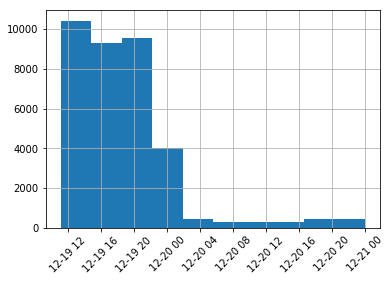

In [17]:
data5.get_sensor_features()
data5.df_features.date.hist(xrot=45)

### Culex pipiens

In [18]:
data6 = Dataset('Wingbeats')
data6.read('C. pipiens', loadmat=False)

data6.get_sensor_features(temp_humd=False)

Data: C. pipiens.
Read 30415 filenames in 2.27 seconds.


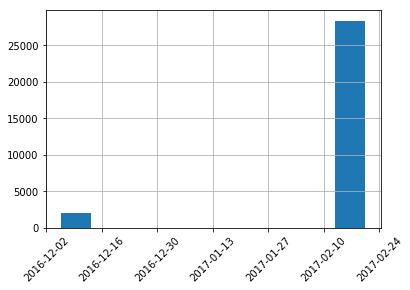

In [19]:
data6.df_features.date.hist(xrot=45)

In [20]:
sub = data6.df_features
inds_6 = sub[sub.date < '2017-01-01'].index

## Creating TRAIN/VAL/TEST sets

In [21]:
def sub_test(dataset, inds):
    X = dataset.filenames.loc[~dataset.filenames.index.isin(inds)]
    y = dataset.y.loc[~dataset.y.index.isin(inds)]
    X_test = dataset.filenames.loc[dataset.filenames.index.isin(inds)]
    y_test = dataset.y.loc[dataset.y.index.isin(inds)]
    return X, y, X_test, y_test

x1, y1, xt1, yt1 = sub_test(data1, inds_1)
x2, y2, xt2, yt2 = sub_test(data2, inds_2)
x3, y3, xt3, yt3 = sub_test(data3, inds_3)
x4, y4, xt4, yt4 = sub_test(data4, inds_4)
x5, y5, xt5, yt5 = sub_test(data5, inds_5)
x6, y6, xt6, yt6 = sub_test(data6, inds_6)

In [22]:
X_test = pd.concat([xt1,xt2,xt3,xt4,xt5,xt6], axis=0).tolist()
y_test = pd.concat([yt1,yt2,yt3,yt4,yt5,yt6], axis=0).tolist()

In [23]:
X = pd.concat([x1,x2,x3,x4,x5,x6], axis=0).tolist()
y = pd.concat([y1,y2,y3,y4,y5,y6], axis=0).tolist()

df = pd.DataFrame({"X": X, "y":y})
df.drop(index=df[df['y'] == 'Ae. aegypti'].sample(38345).index.values, inplace=True)
X,y = df.X.values, df.y.values

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)
y_test = le.fit_transform(y_test)

In [24]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X,y = shuffle(X,y, random_state=0)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [26]:
pd.Series(y_train).value_counts()
# le.inverse_transform(y_train)

3    36454
0    35645
5    26280
4    22760
1    14016
2    13183
dtype: int64

# Modelling

In [27]:
from utils_train import *
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.utils import to_categorical
from wavhandler import *
import math

In [28]:
model_name='mosquitoes_validation' 
setting='raw'
top_weights_path = TEMP_DATADIR + str(model_name) + '.h5'
targets = 6
batch_size = 32

# Build the Neural Network
model = Sequential()

model.add(Conv1D(16, 3, activation='relu', input_shape=(5000, 1)))
model.add(Conv1D(16, 3, activation='relu'))
model.add(BatchNormalization())

model.add(Conv1D(32, 3, activation='relu'))
model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(Conv1D(256, 3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())

model.add(Dropout(0.5))
model.add(Dense(targets, activation='softmax'))

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

callbacks_list = [ModelCheckpoint(top_weights_path, monitor = 'val_acc', verbose = 1, save_best_only = True, save_weights_only = True),
    EarlyStopping(monitor = 'val_acc', patience = 6, verbose = 1),
    ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, patience = 3, verbose = 1),
    CSVLogger('model_' + str(model_name) + '.log')]

target_names = list(np.unique(y))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
model.fit_generator(train_generator(X_train, y_train, batch_size=batch_size,
                                   target_names=target_names,
                                   setting=setting),
                   steps_per_epoch = int(math.ceil(float(len(X_train)) / float(batch_size))),
                   epochs=100,
                   validation_data = valid_generator(X_val, y_val,
                                                    batch_size=batch_size,
                                                    target_names=target_names,
                                                    setting=setting),
                    validation_steps=int(math.ceil(float(len(X_test))/float(batch_size))),
                    callbacks = callbacks_list)

In [29]:
model.load_weights(top_weights_path)
y_pred = model.predict_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=batch_size, 
                                                    setting=setting, 
                                                    target_names=target_names),
        steps = int(math.ceil(float(len(X_test)) / float(batch_size))))

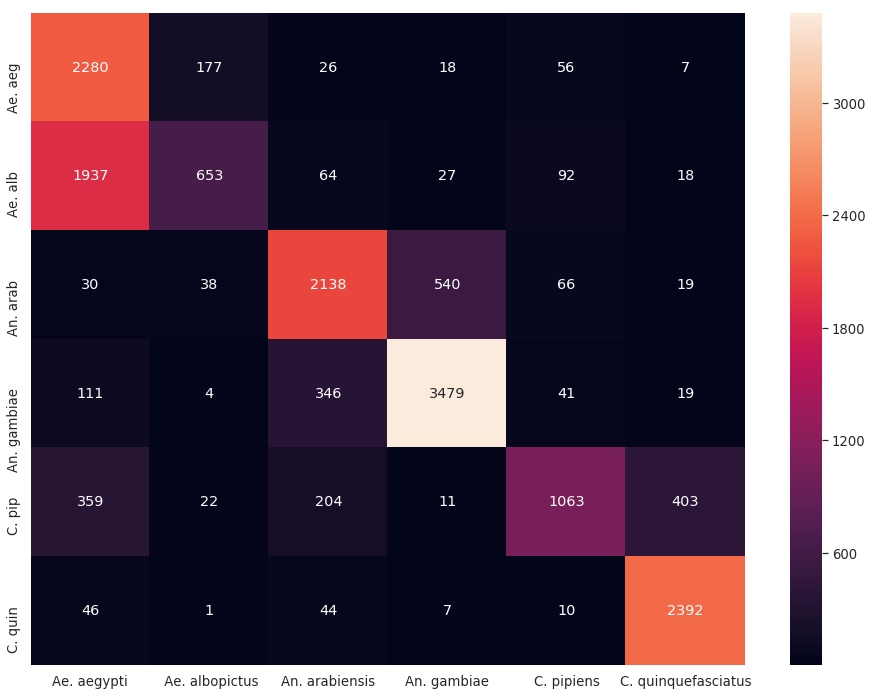

In [30]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
x = confusion_matrix(np.array(y_test), np.argmax(y_pred, axis=1))

plt.figure(figsize=(16,12))
sns.set(font_scale=1.2)
ticks = ['Ae. aegypti',' Ae. albopictus','An. arabiensis','An. gambiae','C. pipiens','C. quinquefasciatus']
ticks_short = ['Ae. aeg','Ae. alb','An. arab','An. gambiae','C. pip','C. quin']
sns.heatmap(x, annot=True, fmt='.0f', xticklabels=ticks, yticklabels=ticks_short)

In [ ]:
model.load_weights(top_weights_path)
loss, acc = model.evaluate_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=batch_size, 
                                                    setting=setting, 
                                                    target_names=target_names),
        steps = int(math.ceil(float(len(X_test)) / float(batch_size))))

print('loss', loss)
print('Test accuracy:', acc)